In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

from scipy.stats import norm
%load_ext autoreload
%autoreload 2

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from dpk.koopman_probabilistic import KoopmanProb
from dpk.model_objs import NormalNLL

[ Using Seed :  633  ]


In [3]:

def normal_lik(data, mean_hat, std_hat):
    """geoemtric mean of the likelihood of data given a normal distribution"""
    assert(len(data) == len(mean_hat) and len(mean_hat) == len(std_hat))
    log_lik = np.mean(np.log(norm.pdf(data, loc=mean_hat, scale=std_hat)))
    return np.exp(log_lik)

def nmb(data, pred):
    """Normalized mean bias"""
    assert(len(data) == len(pred))
    return np.mean(pred - data) / np.mean(data)

def nrmse(data, pred):
    """Normalized root mean square error"""
    assert(len(data) == len(pred))
    sorted_data = sorted(data)
    o05 = sorted_data[int(len(data) * 0.05)]
    o95 = sorted_data[int(len(data) * 0.95)]
    return float(np.sqrt(np.mean((data - pred)**2)) / (o95 - o05))

from scipy.stats import pearsonr
def correlation(data, pred):
    """Pearson correlation"""
    assert(len(data) == len(pred))
    return pearsonr(data, pred)[0]

In [4]:
import json
with open(".\\HighNO2\\HighNO2.json") as f:
    HighNO2 = json.loads(f.read())
HighNO2

{'EEA_FR_FR04012': {},
 'EEA_FR_FR04058': {'pre-covid': {'gm_lik': 0.2640757419911648,
   'nmb': -0.036969260380600215,
   'nrmse': 0.28291320071103665,
   'correlation': 0.4285374260460674},
  'covid': {'gm_lik': 0.08201014698970246,
   'nmb': 0.8267974213711774,
   'nrmse': 0.6041317437426168,
   'correlation': 0.286529878333756}},
 'EEA_FR_FR04131': {'pre-covid': {'gm_lik': 0.31651388905622035,
   'nmb': -0.11522898797471556,
   'nrmse': 0.27375085204980243,
   'correlation': 0.551773789441507},
  'covid': {'gm_lik': 0.13361281050565493,
   'nmb': 1.3044160563184377,
   'nrmse': 0.6741951690335081,
   'correlation': 0.08057030690717298}},
 'Station0005229': {'pre-covid': {'gm_lik': 0.22245721778163705,
   'nmb': -0.13958738917891847,
   'nrmse': 0.2823863375112016,
   'correlation': 0.5665928549016227},
  'covid': {'gm_lik': 0.13593047507413314,
   'nmb': 1.5494469802972366,
   'nrmse': 0.8687982520431722,
   'correlation': 0.24616327099308524}}}

In [345]:
station_name = "Station0005229"
station_fname = f"obs_{station_name}.csv"

In [346]:
station_path = ".\\HighNO2\\"
for fname in os.listdir(station_path):
    if fname.startswith("obs_") and fname[len("obs_"):-len(".csv")] not in HighNO2.keys():
        station_name = fname[len("obs_"):-len(".csv")]
        break
station_name

'Station0005229'

In [347]:
HighNO2[station_name] = {"pre-covid": dict(), "covid": dict()}

In [348]:
if station_fname.startswith("obs"):
    obsfile = os.path.join(station_path, station_fname)
    obs = pd.read_csv(obsfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
    t_min = obs.t.min()
    obs.t -= t_min
    obs_no2 = obs.loc[obs.obstype=='no2']
 
    obs_no2

In [349]:
if station_fname.startswith("model_analysis"):
    modfile = os.path.join(station_path, station_fname)
    mod = pd.read_csv(modfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
    mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]
    t_min = mod.t.min()
    mod .t -= t_min

    mod

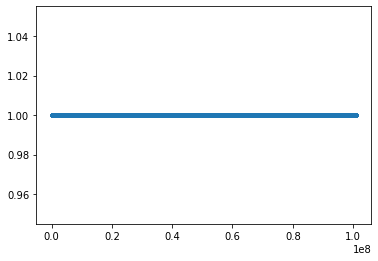

In [350]:
plt.plot(obs.t, np.ones(len(obs.t)), ".")

x (22676, 1)
t (22676,)
[14932]
nonpositive observed concentration:  [0.]
x (22676, 1)
t (22676,)


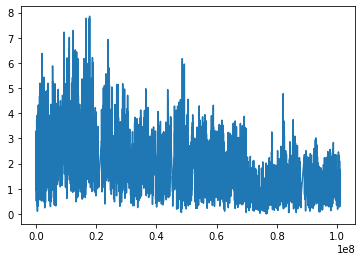

In [351]:
chemical = "NO2"
if station_fname.startswith("obs"):
    x = np.expand_dims(obs_no2.conc_obs.values, -1)
    t = obs_no2.t.values
else:
    x = np.expand_dims(mod.no2.values, -1)
    t = mod.t.values
print("x", x.shape)
print("t", t.shape)
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2
if x.min() <= 0:
    print("nonpositive observed concentration: ", x[x<=0])
    x[x <= 0] = 1e-20
x_original = x
scale = np.std(x, axis=0)
x = x / np.tile(scale, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)
plt.figure()
plt.plot(t, x)

x (17098, 1)
x_train (14232, 1)


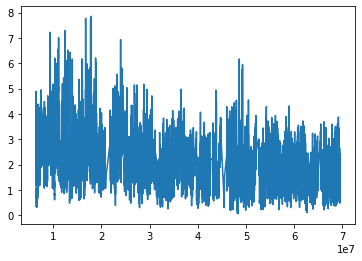

In [352]:
train_start_date = np.datetime64("2018-03-16")
train_end_date = np.datetime64("2020-03-16")
covid_end_date = np.datetime64("2020-05-16")
train_start = np.argwhere(obs_no2.ISO8601.values >= train_start_date)[0, 0]
train_end = np.argwhere(obs_no2.ISO8601.values <= train_end_date)[-1, 0]
covid_end = np.argwhere(obs_no2.ISO8601.values <= covid_end_date)[-1, 0]
data_name = chemical + station_name

x = x[:covid_end]
t = t[:covid_end]

delay = 0

x_train = x[train_start:train_end]
t_train = t[train_start:train_end]

now = ("_".join(str(datetime.now()).split())).replace(":", ".")
print("x", x.shape)
print("x_train", x_train.shape)
plt.figure()
plt.plot(t_train, x_train)
plt.show()

In [353]:
train_start, train_end, covid_end

(1648, 15880, 17098)

In [356]:
periods = 60 * 60 * np.array([24, 24 * 7, 24 * 365.24], dtype=np.float64)  # seconds
l1width = 256
l2width = 1024
wd = 1e-3
lrt = 1e-4
batch_size = 32
model = NormalNLL(x_dim=1, num_freqs=3, n=l1width, n2=l2width)

total_iters = 200
param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
model.load_state_dict(torch.load(f"forecasts/model_{param_str}.pt"))

k = KoopmanProb(model, batch_size=batch_size, device="cpu")
k.init_periods(periods)
total_iters = 0

In [355]:
iters = 200
total_iters += iters
k.fit(x_train, t_train, iterations=iters, cutoff=0, weight_decay=wd, lr_theta=lrt, lr_omega=0, verbose=True)

Iteration  0
tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000])
Setting periods to tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000], grad_fn=<MulBackward0>)
Loss:  0.27306116
Iteration  1
tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000])
Setting periods to tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000], grad_fn=<MulBackward0>)
Loss:  0.27248344
Iteration  2
tensor([   86400.0000,   604800.0625, 31556736.0000,    86400.0000,
          604800.0625, 31556736.0000])


KeyboardInterrupt: 

In [357]:
params = k.predict(t)
mu_hat, sigma_hat = params
mean_hat = model.mean(params)
std_hat = model.std(params)

In [149]:
param_str = f"NormalNLL_{station_fname[:-4]}_{l1width}_{l2width}_{k.batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
np.save(f"forecasts/params_{param_str}.npy", np.array(params))
torch.save(model.state_dict(), f"forecasts/model_{param_str}.pt")

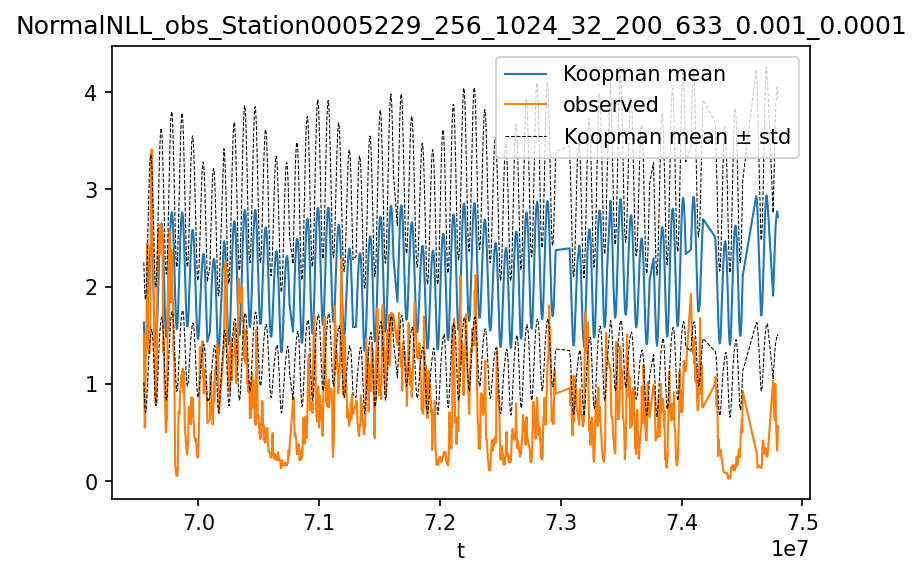

In [358]:
mean_hat = model.mean(params)
std_hat = model.std(params)
plt.figure(dpi=150)
plt.plot(t[train_end:], mean_hat[train_end:, 0], label="Koopman mean", linewidth=1)
plt.plot(t[train_end:], x[train_end:, 0], label="observed", linewidth=1)
plt.plot(t[train_end:], mean_hat[train_end:, 0] + std_hat[train_end:, 0], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(t[train_end:], mean_hat[train_end:, 0] - std_hat[train_end:, 0], "--", color="black", linewidth=0.5)

plt.title(f"{param_str}")
plt.xlabel("t")
# plt.xlim([7e7, 7.1e7])
plt.legend()
plt.show()

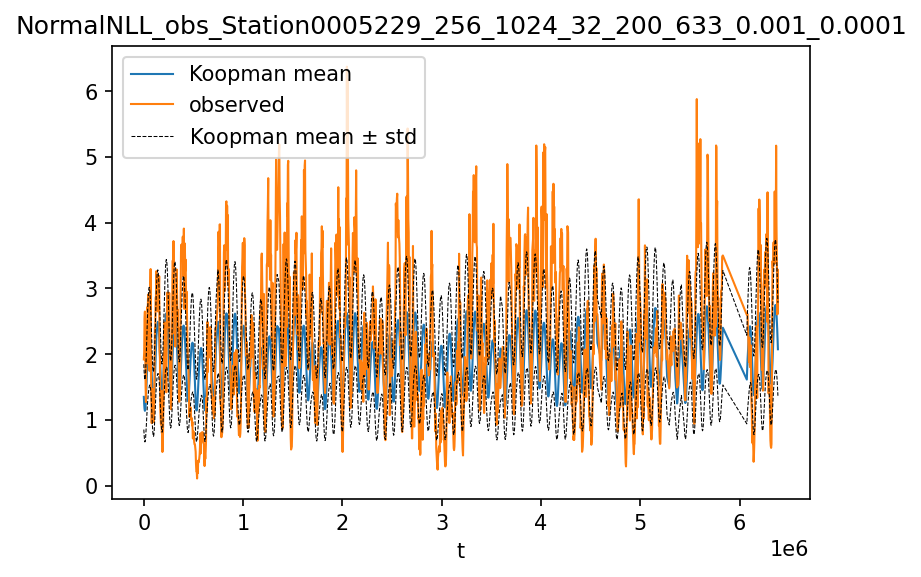

In [359]:
mean_hat = model.mean(params)
std_hat = model.std(params)
plt.figure(dpi=150)
plt.plot(t[:train_start], mean_hat[:train_start, 0], label="Koopman mean", linewidth=1)
plt.plot(t[:train_start], x[:train_start, 0], label="observed", linewidth=1)
plt.plot(t[:train_start], mean_hat[:train_start, 0] + std_hat[:train_start, 0], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(t[:train_start], mean_hat[:train_start, 0] - std_hat[:train_start, 0], "--", color="black", linewidth=0.5)

plt.title(f"{param_str}")
plt.xlabel("t")
plt.legend()
plt.show()

In [360]:
len(x), len(mean_hat), len(std_hat)

(17098, 17098, 17098)

In [273]:
HighNO2[station_name]["pre-covid"]["gm_lik"] = normal_lik(x[0:train_start], mean_hat[0:train_start], std_hat[0:train_start])
HighNO2[station_name]["pre-covid"]["nmb"] = nmb(x[0:train_start], mean_hat[0:train_start])
HighNO2[station_name]["pre-covid"]["nrmse"] = nrmse(x[0:train_start], mean_hat[0:train_start])
HighNO2[station_name]["pre-covid"]["correlation"] = correlation(x[0:train_start, 0], mean_hat[0:train_start, 0])

HighNO2[station_name]["covid"]["gm_lik"] = normal_lik(x[train_end:], mean_hat[train_end:], std_hat[train_end:])
HighNO2[station_name]["covid"]["nmb"] = nmb(x[train_end:], mean_hat[train_end:])
HighNO2[station_name]["covid"]["nrmse"] = nrmse(x[train_end:], mean_hat[train_end:])
HighNO2[station_name]["covid"]["correlation"] = correlation(x[train_end:, 0], mean_hat[train_end:, 0])
HighNO2[station_name]

{'pre-covid': {'gm_lik': 0.09258495105065123,
  'nmb': 0.6669394597837389,
  'nrmse': 0.553388944137436,
  'correlation': -0.15157432477422228},
 'covid': {'gm_lik': 0.05972745884613754,
  'nmb': 0.7046231726163847,
  'nrmse': 0.48354430344642824,
  'correlation': -0.13268842052330207}}

In [170]:
with open(".\\HighNO2\\HighNO2.json", "w") as f:
    f.write(json.dumps(HighNO2))

In [361]:
print(normal_lik(x[train_start:train_end], mean_hat[train_start:train_end], std_hat[train_start:train_end]))
print(nmb(x[train_start:train_end], mean_hat[train_start:train_end]))
print(nrmse(x[train_start:train_end], mean_hat[train_start:train_end]))
print(correlation(x[train_start:train_end, 0], mean_hat[train_start:train_end, 0]))

0.3037279242641391
-0.005302648484333317
0.27395742384820704
0.48264486132120776


ideas:
- make calibration diagram
    - quantify this with the NMAE from uniform? (also incorporate sample size, independence)
- threshhold on some metric (like a probability of some statistic being as extreme or more extreme than some value)

In [362]:
# find the sampling distribution of consecutive k-averages (k_average = average z-score of k consecutive observations)
k = 24 * 7
z_scores = (x - mean_hat) / std_hat
k_averages = []

for i in range(0, covid_end - k + 1):
    k_average = np.mean(z_scores[i:i+k])
    k_averages.append(k_average)

In [363]:
alpha = 0.001
train_k_averages = k_averages[train_start:train_end - k + 1]
covid_k_averages = k_averages[train_end:]
control_k_averages = k_averages[:train_start - k + 1]
critical_z_bar = sorted(train_k_averages)[int(len(train_k_averages) * alpha)]

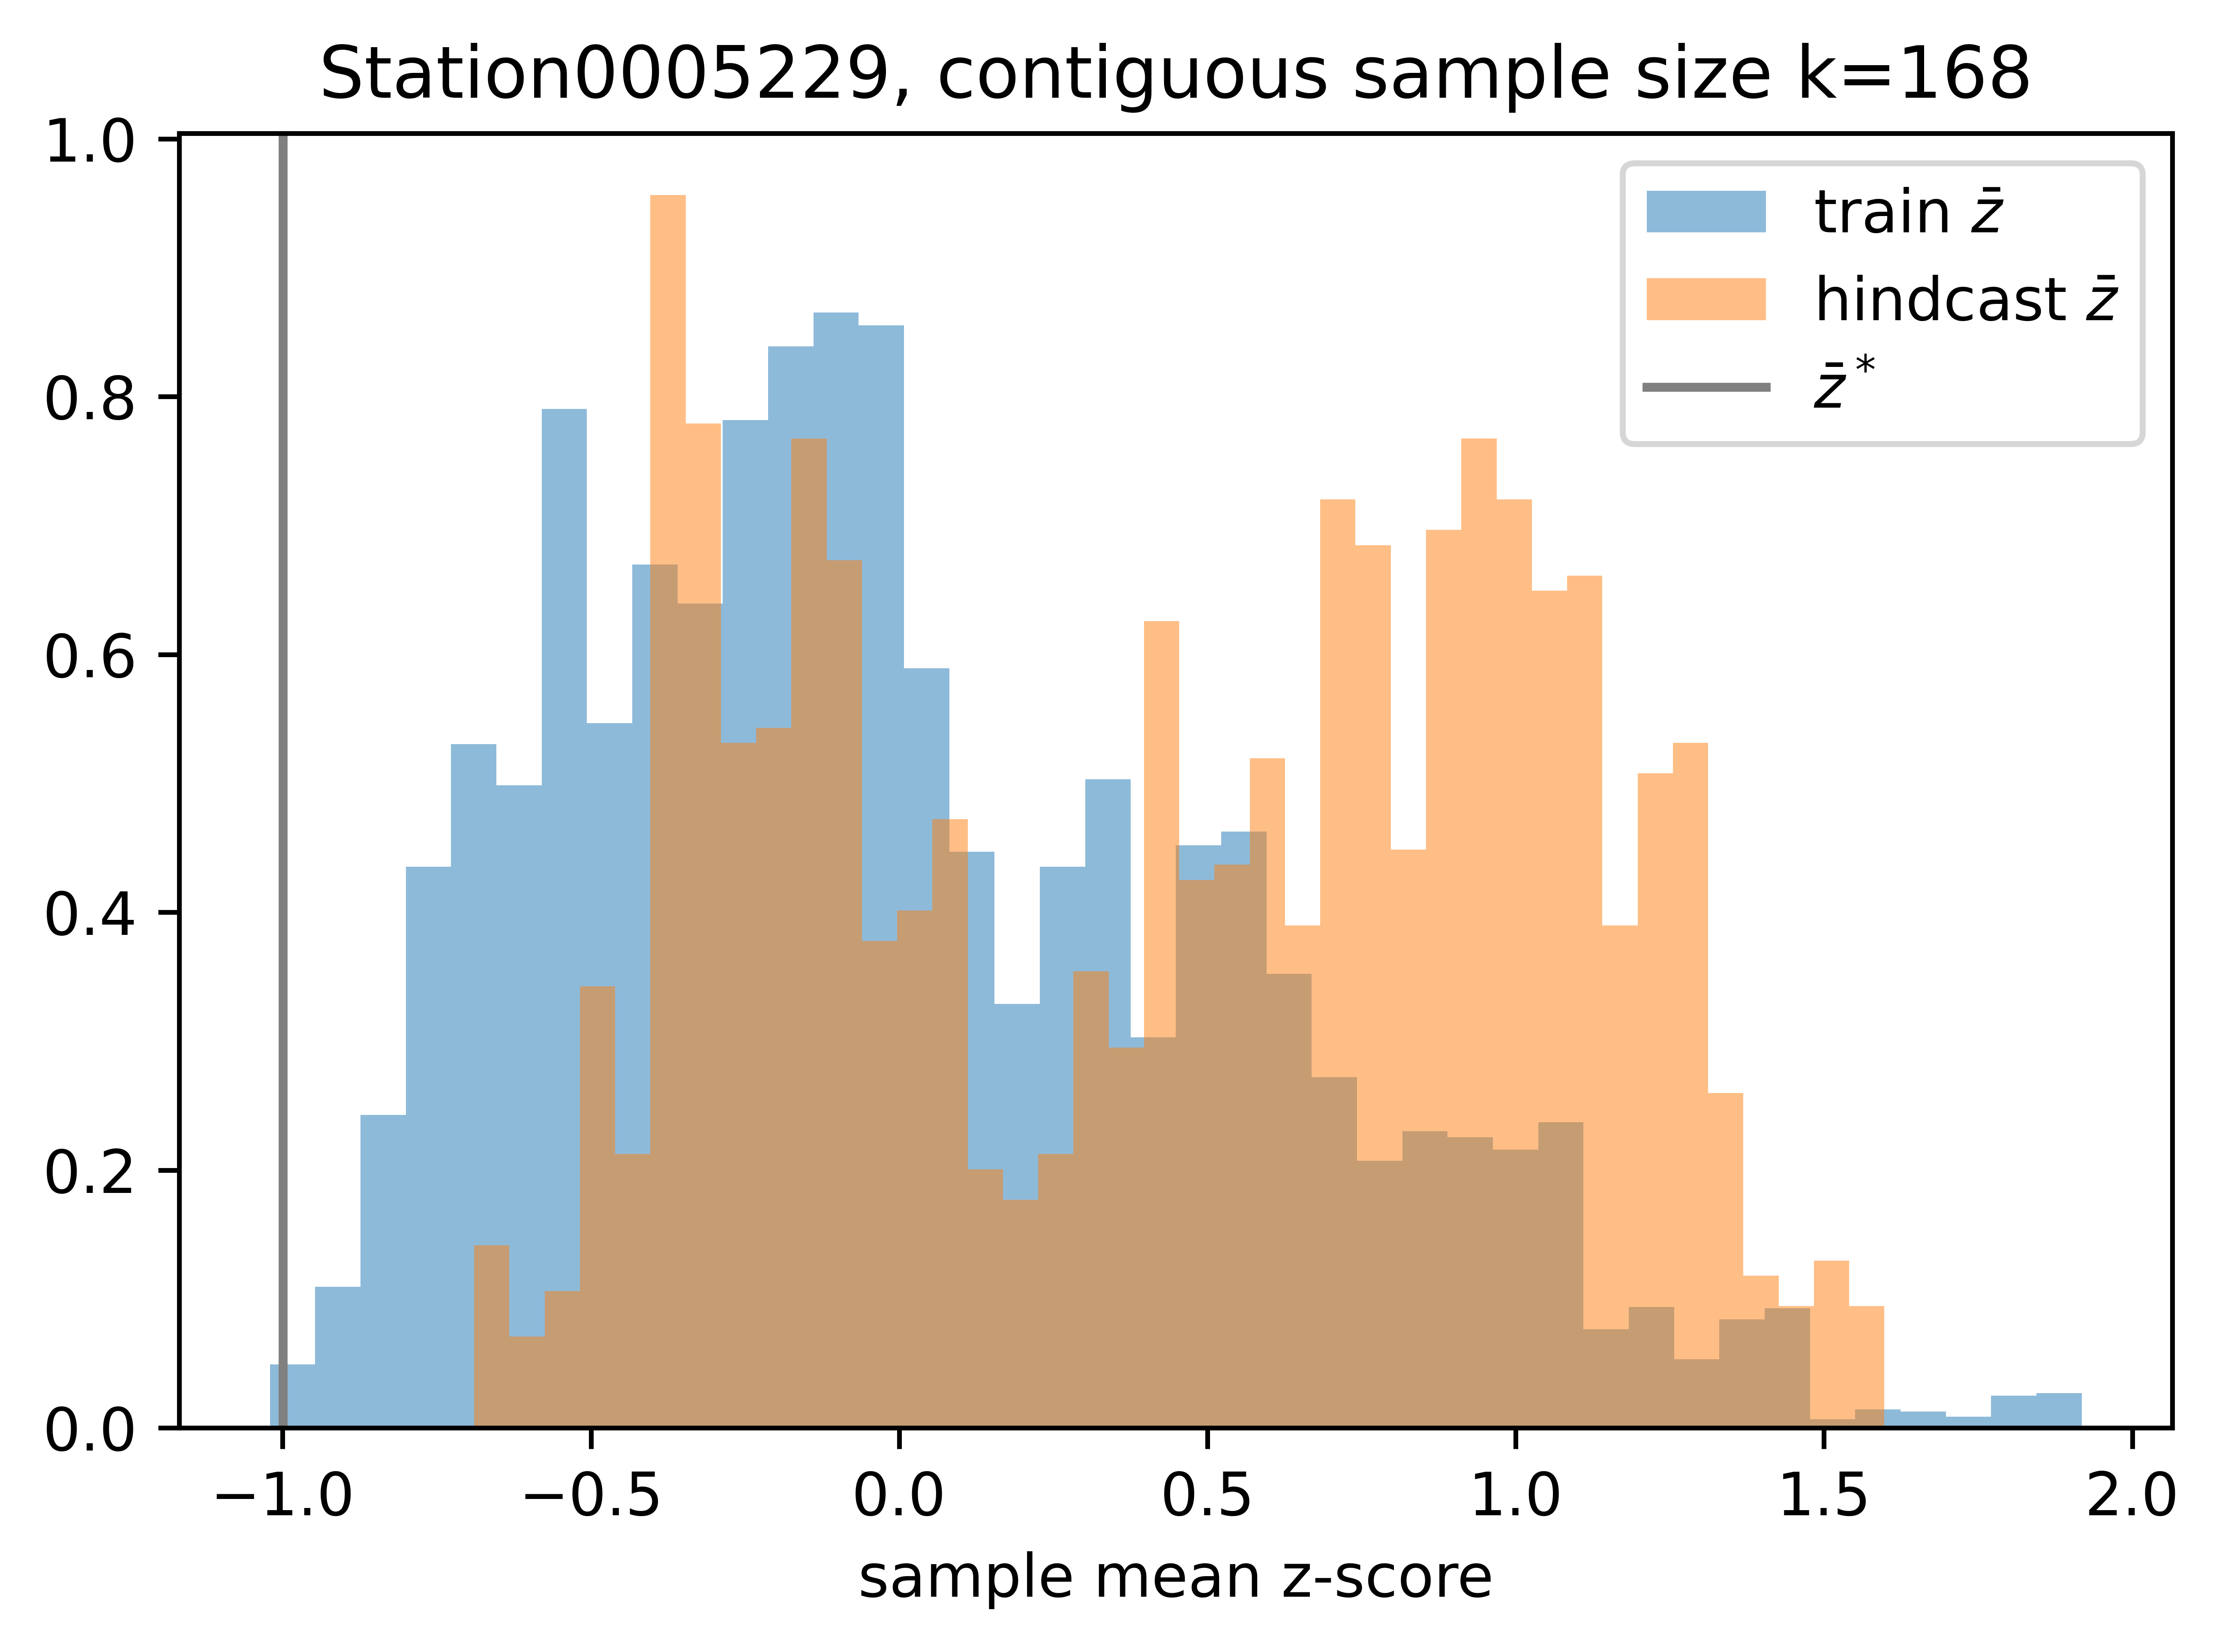

In [366]:
plt.figure(dpi=1000)
plt.hist(train_k_averages, bins=40, density=True, color="tab:blue", alpha=0.5, label="train $\\bar z$")
plt.hist(control_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="hindcast $\\bar z$")
# plt.hist(covid_k_averages, bins=40, density=True, color="tab:orange", alpha=0.5, label="covid $\\bar z$")
plt.axvline(critical_z_bar, color="gray", label="$\\bar z^*$")
plt.title(f"{station_name}, contiguous sample size k={k}")
plt.xlabel("sample mean z-score")
l = np.linspace(min(train_k_averages), max(train_k_averages))
# if consecutive z-scores were iid, we would expect this distribution to have std = 1/sqrt(k)
# plt.plot(l, norm.pdf(l, loc=0, scale=1/np.sqrt(k)), label="sample mean of iid z-scores")
plt.legend()